In [1]:
import numpy as np
import scipy as sp
import scipy.io as sio
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap import UMAP

In [2]:
arr1 = sio.loadmat('data/EID-M.mat')
arr2 = sio.loadmat('data/EID-S.mat')
arr3 = sio.loadmat('data/EEG_ID_label6.mat')

(
    arr1['eeg_close_ubicomp_8sub'].shape, 
    arr2['eeg_close_8sub_1file'].shape, 
    arr3['EEG_ID_label6'].shape
)

((168000, 15), (56000, 15), (108000, 66))

In [4]:
X = arr1['eeg_close_ubicomp_8sub'][:, :14]

X = np.concatenate([
    X[7000 * i : 7000 * (i + 1)]
    for i in range(24)
], axis = 1).T
X = (X - X.mean(1).reshape((-1, 1))) / X.std(1).reshape((-1, 1))
X.shape

(336, 7000)

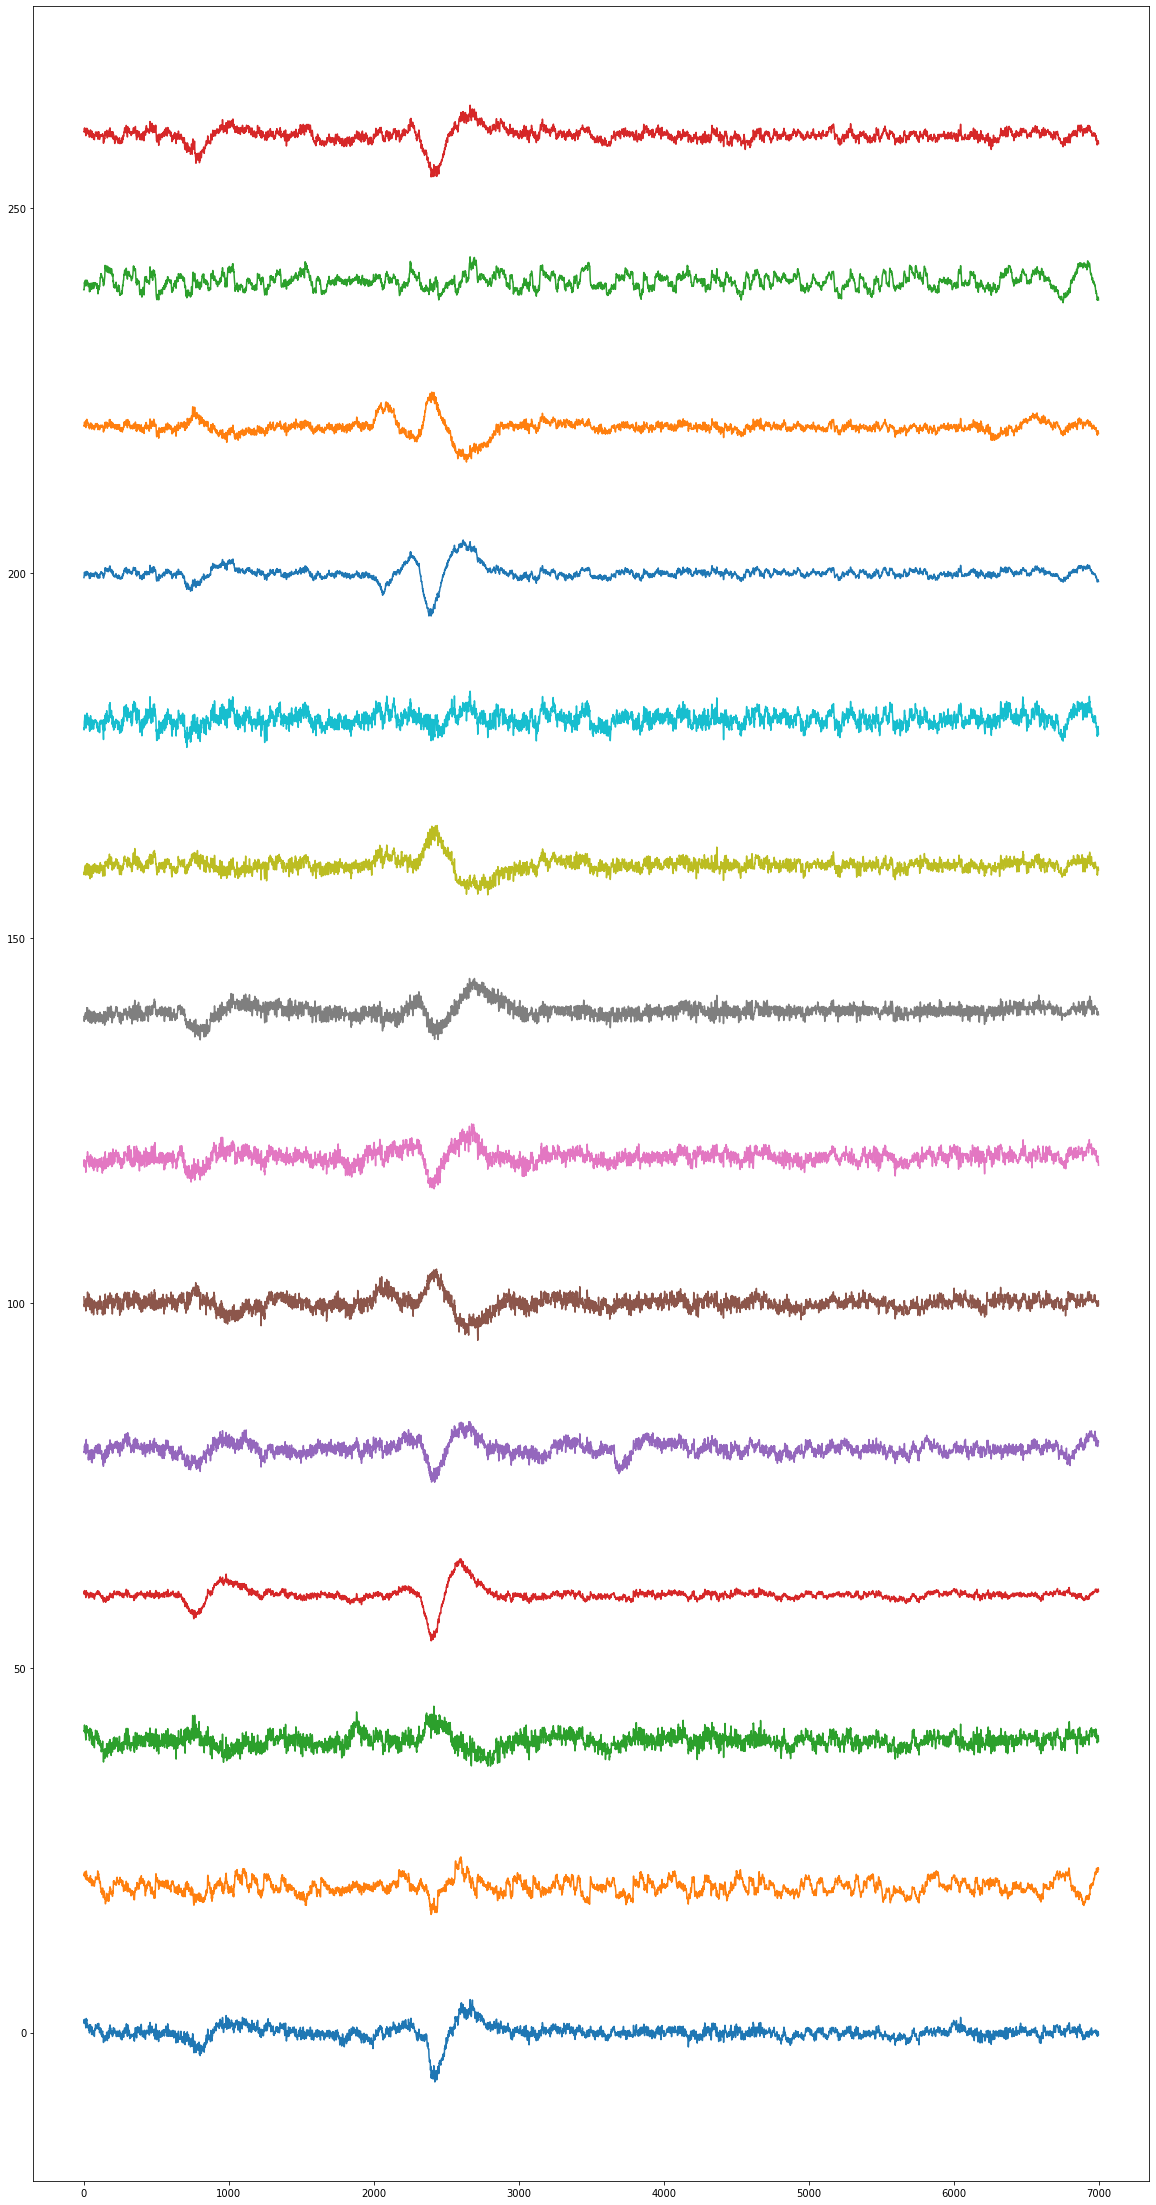

In [5]:
plot_n = 14

plt.figure(figsize = (20, 40))
for row in X[:plot_n] + (np.arange(plot_n) * 20).reshape((-1, 1)):
    plt.plot(row)
plt.show()

In [10]:
time_in  = 32
time_out = 16

input_layer = layers.Input((time_in, 1))
l1 = layers.LSTM(50, activity_regularizer = keras.regularizers.L2(0.05))(input_layer)
# l2 = layers.Dense()
l3 = layers.Dense(time_out)(l1)

model = keras.Model(input_layer, l3)
model.compile(
    optimizer = keras.optimizers.Adadelta(0.1),
    loss = 'mse'
)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 1)]           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                816       
Total params: 11,216
Trainable params: 11,216
Non-trainable params: 0
_________________________________________________________________


In [11]:
X_train = []
y_train = []

per_channel = 1000
for idx in range(X.shape[0]):
    for _ in range(per_channel):
        rnd = np.random.randint(0, X.shape[1] - (time_in + time_out))
        X_train.append(X[idx][rnd : rnd + time_in])
        y_train.append(X[idx][rnd : rnd + time_out])
        
X_train = np.stack(X_train).reshape((-1, time_in , 1))
y_train = np.stack(y_train).reshape((-1, time_out, 1))
X_train.shape, y_train.shape

((336000, 32, 1), (336000, 16, 1))

In [12]:
train_n = 300000

hist = model.fit(
    X_train[:train_n], y_train[:train_n],
    batch_size = 1024,
    validation_split = 0.2,
    epochs = 50
)

Epoch 1/50
235/235 [==============================] - 3s 7ms/step - loss: 0.8912 - val_loss: 0.5866
Epoch 2/50
235/235 [==============================] - 1s 6ms/step - loss: 0.5097 - val_loss: 0.5017
Epoch 3/50
235/235 [==============================] - 1s 6ms/step - loss: 0.4415 - val_loss: 0.4768
Epoch 4/50
235/235 [==============================] - 1s 6ms/step - loss: 0.3788 - val_loss: 0.3936
Epoch 5/50
235/235 [==============================] - 1s 6ms/step - loss: 0.3318 - val_loss: 0.3696
Epoch 6/50
235/235 [==============================] - 1s 6ms/step - loss: 0.3101 - val_loss: 0.3559
Epoch 7/50
235/235 [==============================] - 1s 6ms/step - loss: 0.2956 - val_loss: 0.3513
Epoch 8/50
235/235 [==============================] - 1s 6ms/step - loss: 0.2865 - val_loss: 0.3307
Epoch 9/50
235/235 [==============================] - 1s 6ms/step - loss: 0.2745 - val_loss: 0.3246
Epoch 10/50
235/235 [==============================] - 1s 6ms/step - loss: 0.2654 - val_loss: 0.3141

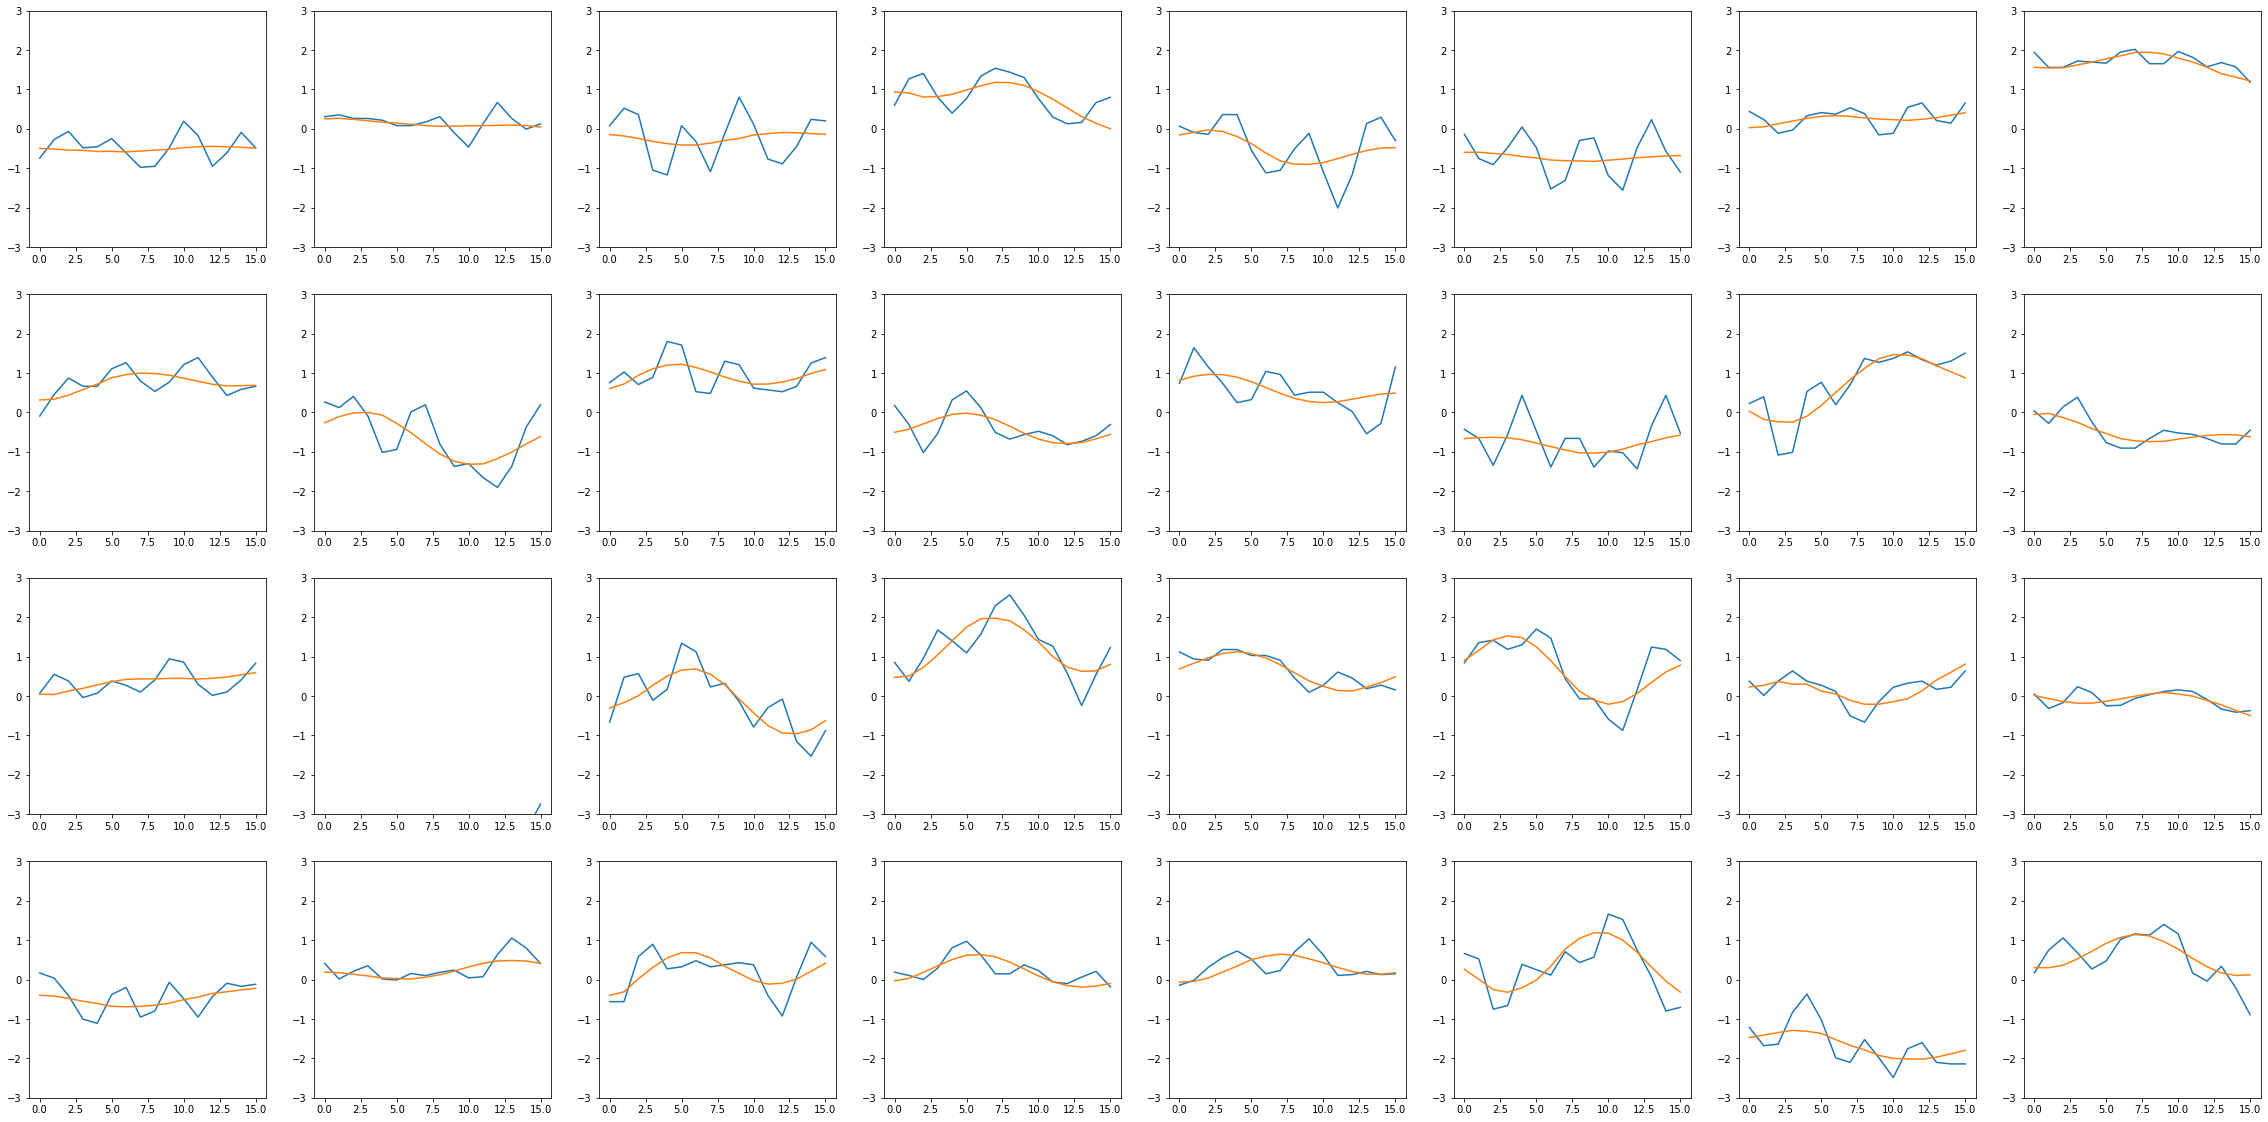

In [13]:
test = model(X_train[train_n:]).numpy()

rows = 4
cols = 8
plt.figure(figsize = (5 * cols, 5 * rows))
axes = [plt.subplot(rows, cols, idx + 1) for idx in range(rows * cols)]

idxs = np.arange(test.shape[0])
np.random.shuffle(idxs)
idxs = idxs[:rows * cols]

for ax, idx in zip(axes, idxs):
    ax.plot(y_train[train_n:][idx])
    ax.plot(test[idx])
    ax.set_ylim(-3, 3)
plt.show()